In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
from typing import List
import copy

In [56]:
# Given a (relative) filepath to a csv output from the scope, returns two arrays
# first array: time in seconds, second array: signal in volts
def load_scope_data(filepath):
    data = pd.read_csv(filepath, skiprows=2, header=None)

    time_seconds = np.array(data[0].values)  # First column is time
    voltage_volts = np.array(data[1].values)  # Second column is voltage

    # Adjust time to start at zero
    time_zero_based = time_seconds - time_seconds.min()
    return (time_zero_based, voltage_volts)


In [58]:
@dataclass
class ScopeData:
    filepath: str 
    # Each entry is the average value for the timestep
    # columns are timesteps, rows are the different channels. should be 8xN where N= num timesteps
    channel_data : List[List[float]]
    # array with similar dimensions to channel_data, contains the times corresponding 
    # to the points in the channel data for each channel 
    times : List[List[float]]

1.000000000001e-06


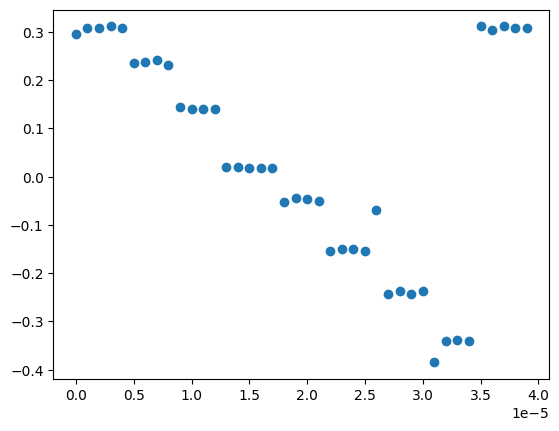

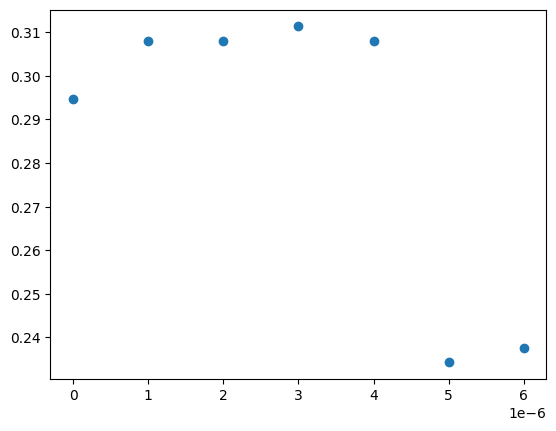

[0.0000e+00 1.0000e-06 2.0000e-06 ... 6.3989e-02 6.3990e-02 6.3991e-02]


In [57]:
# I'm going to manually describe the starting conditions of the 8 csv's I have
ts, vs = load_scope_data("./scope traces/herzan64mscsv2.csv")
print(ts[1] - ts[0])
end_point = 40
plt.scatter(ts[:end_point], vs[:end_point]) #, s=np.ones_like(ts[:40]))
plt.show()
end_point = 7
plt.scatter(ts[:end_point], vs[:end_point]) #, s=np.ones_like(ts[:40]))
plt.show()
print(ts)

In [60]:
# Processes the data in the files in ./scope traces and creates a list of 
# ScopeData classes that have easy to manipulate data stored in them for each channel
# Not processing channel 1 since the data in it is formattted differently from the rest
scope_datas = []
for i in range(2, 6):
    # get the file
    filepath = "./scope traces/herzan64mscsv{}.csv".format(i)
    times, voltages = load_scope_data(filepath)

    # initialize where processed data will be saved
    avg_times = [[] for _ in range(8)] # avg time of each channel timestep
    data = [[] for _ in range(8)] # avg voltage for each channel at times in avg_times

    # iteration variables
    curr_channel = 0 # counter to keep track of which channel is active
    step_end = 4.5e-6 # time where the current step ends (us)
    step_width = 5.0e-6 # width of a timestep for multiplexing (us)
    curr_time_average = 0.0 # current time averager
    curr_volt_average = 0.0 # currrent voltage average
    n_points = 0.0 # number of points being averaged now
    for i in range(len(times)):
        if times[i] < step_end:
            curr_time_average += times[i]
            curr_volt_average += voltages[i]
            n_points += 1
        else:
            # append data from processed timestep
            avg_times[curr_channel].append(curr_time_average / n_points)
            data[curr_channel].append(curr_volt_average / n_points)

            # reset iteration trackers
            curr_channel = (curr_channel + 1) % 8
            n_points = 0.0
            curr_volt_average = 0.0
            curr_time_average = 0.0
            step_end += step_width

    # Add the processed data to the scope_datas list
    scope_datas.append(ScopeData(filepath, copy.deepcopy(data), copy.deepcopy(avg_times)))
print(scope_datas)

[ScopeData(filepath='./scope traces/herzan64mscsv2.csv', channel_data=[[np.float64(0.30594143200000007), np.float64(0.21255230749999998), np.float64(0.13891214), np.float64(0.019246859999999998), np.float64(-0.04769875), np.float64(-0.15062762), np.float64(-0.23933055), np.float64(-0.33807532), np.float64(0.3179916425), np.float64(0.2535564925), np.float64(0.1598326425), np.float64(0.045188284999999995), np.float64(-0.0359832675), np.float64(-0.101255235), np.float64(-0.19665272499999997), np.float64(-0.29288703499999996), np.float64(-0.0167364), np.float64(0.2928870375), np.float64(0.21171548750000002), np.float64(0.13389122), np.float64(0.042677822500000004), np.float64(-0.04853557), np.float64(-0.15062762), np.float64(-0.24435147), np.float64(-0.34309623999999994), np.float64(0.31213389999999996), np.float64(0.2552301325), np.float64(0.13472804), np.float64(0.02426778), np.float64(-0.058577409999999996), np.float64(-0.12301255750000001), np.float64(-0.197489545), np.float64(-0.29205

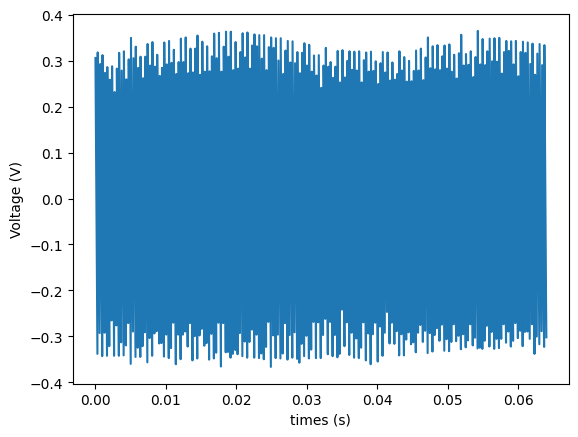

C:\Users\bahaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\bahaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'idk honestly')

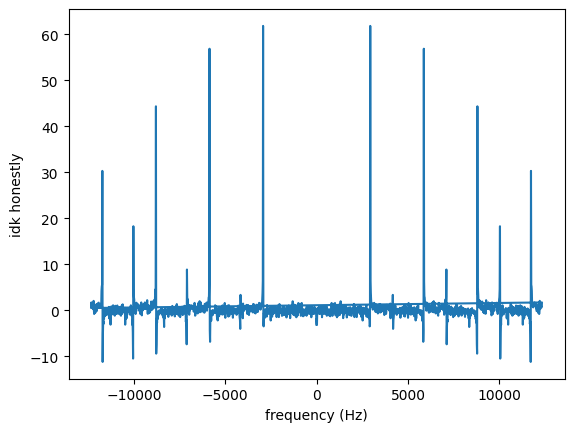

In [ ]:
# Sample plots for channel 1, file 2
# Plot the voltage in time
scopedata = scope_datas[0]
voltages = scopedata.channel_data[0]
times = scopedata.times[0]
plt.plot(times, voltages)
plt.xlabel("times (s)")
plt.ylabel("Voltage (V)")
plt.show()

# Plot the fft (idk what the units of the y axis would be)
dt = times[1] - times[0]
fft = np.fft.fft(voltages)
freqs = np.fft.fftfreq(len(voltages), d=dt)
plt.plot(freqs, fft)
plt.xlabel("frequency (Hz)")
plt.ylabel("idk honestly") # need to know how to translate volts to amplitude of noise
plt.show()